# Group-level satistical analysis of brain electrical properties - Experiment n°2
This notebook presents the second experiment of the group level statistical analysis of brain electrical properties ($\sigma$ and $\epsilon_r$). In this experiment we assess the consistency of the decrease in brain conductivity across GRE, EPI and TSE measurements. To provide a fair comparison of GRE, EPI and TSE neonatal conductivity measurements, we only considered subjects for which all three $\sigma$ measurements were available ($n = 725$).

Part of nano-eptk package by Arnaud Boutillon (arnaud.boutillon@kcl.ac.uk).

## Python environment setting

In [1]:
import os
import sys
import warnings

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

from scipy.stats import ttest_1samp

base_dir = os.path.abspath(os.path.join(os.path.pardir, os.path.pardir))
sys.path.append(os.path.join(base_dir))

from utils.stats import *
from utils.plots import *

sns.set_theme(style="darkgrid")
warnings.filterwarnings("ignore")

## 1. Extraction of neonatal GRE, EPI and TSE measurements with covariates of interest
The covariates of interest include post-menstrual age (PMA) and preterm birth (PTB).

In [2]:
def merge_dHCP_dfs(csv_dir, df_path):
    # Set file path
    GRE_df_path = os.path.join(csv_dir, "dHCP_GRE.csv")
    EPI_df_path = os.path.join(csv_dir, "dHCP_EPI.csv")
    TSE_df_path = os.path.join(csv_dir, "dHCP_TSE.csv")
    COV_df_path = os.path.join(csv_dir, "dHCP_COV.csv")
    
    # Load dataframes
    GRE_df = pd.read_csv(GRE_df_path)
    EPI_df = pd.read_csv(EPI_df_path)
    TSE_df = pd.read_csv(TSE_df_path)
    COV_df = pd.read_csv(COV_df_path)
    
    # Merge dataframes
    keys = ["subject_id", "PMA"]
    df_temp = COV_df.merge(GRE_df, on=keys, how="inner")
    df_temp = df_temp.merge(EPI_df, on=keys, how="inner")
    df = df_temp.merge(TSE_df, on=keys, how="inner")
    
    # Data headers
    cohorts = ["GRE", "EPI", "TSE"]
    tissues = ["brain", "WM", "dGM"]
    sig = "SIG"
    std = "SIG_std"
    
    # Compute inverse-variance weights and weighted sum
    weights = sum(1 / df[f"{cohort}_{std}"] for cohort in cohorts)
    weighted_sum = sum((1 / df[f"{cohort}_{std}"]) * df[f"{cohort}_{sig}"] for cohort in cohorts)
    
    # Final weighted average
    df[sig] = round(weighted_sum / weights, 4)

    # For each tissue
    for tissue in tissues:
        # Compute inverse-variance weights and weighted sum
        weights = sum(1 / df[f"{cohort}_{tissue}_{std}"] for cohort in cohorts)
        weighted_sum = sum((1 / df[f"{cohort}_{tissue}_{std}"]) * df[f"{cohort}_{tissue}_{sig}"] for cohort in cohorts)
        
        # Final weighted average
        df[f"{tissue}_{sig}"] = round(weighted_sum / weights, 4)

    # Save dataframe
    output_dir = os.path.dirname(df_path)
    os.makedirs(output_dir, exist_ok=True)
    df.to_csv(df_path, index=False)

In [3]:
# Set file path
csv_dir = os.path.join(base_dir, "data", "cohorts_csv")
df_path = os.path.join(csv_dir, "dHCP.csv")

# Merge and load table
merge_dHCP_dfs(csv_dir, df_path)
df = pd.read_csv(df_path)

# Display cohort size
print(f"dHCP sessions n = {len(df.index)}")
print(f"dHCP subjects m = {df['subject_id'].nunique()}")

dHCP sessions n = 725
dHCP subjects m = 650


## 2. Agreement among GRE, EPI and TSE brain conductivity measurements
Paired $\sigma$ distributions were compared using Bland-Altman analysis (i.e. average $\sigma$  vs. difference in $\sigma$) to assess the agreement among GRE, EPI and TSE brain conductivity measurements. We extracted the systematic bias ($\Delta$) between distribution as the mean of $\sigma$ differences and the proportional bias ($\delta$) by fitting a univariate LME model on the Bland-Altman data points. 

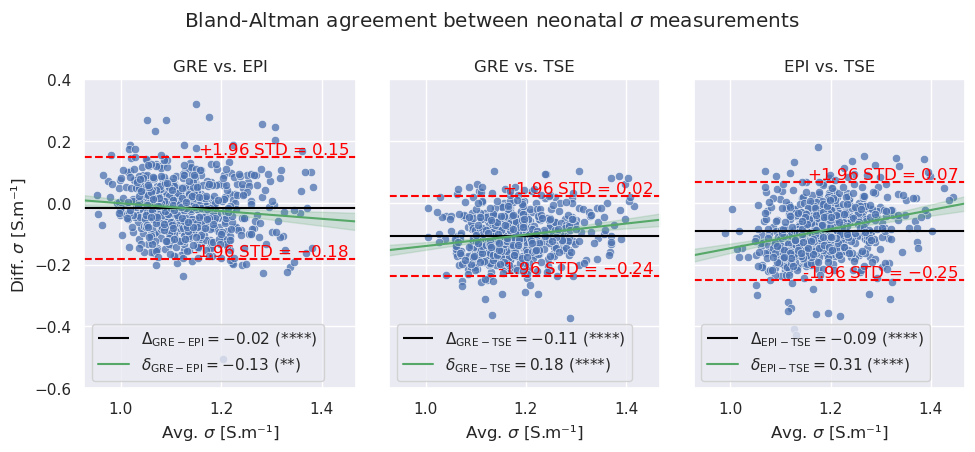

In [4]:
# Set file path
plot_dir = os.path.join(base_dir, "plots", "experiments")
plot_path = os.path.join(plot_dir, "experiment2A.png")

# Load dataframe
df = pd.read_csv(df_path)

# Data header
x_col = "brain_SIG"
cohort_labels = ["GRE", "EPI", "TSE"]
groups_col = "subject_id"
comparisons = [("GRE", "EPI"), ("GRE", "TSE"), ("EPI", "TSE")]

# Axes limits with margin
x = pd.concat(
    [((df[f"{g1}_{x_col}"] + df[f"{g2}_{x_col}"]) / 2)
    for (g1,g2) in comparisons],
)
xlim = calculate_plot_lim(x, coeff_margin=0.05)
ylim = (-0.6, 0.4)

# Initialize plot
fig, axes = plt.subplots(1, 3, figsize=(10,4.6), sharex=True, sharey=True)
fig.suptitle(r"Bland-Altman agreement between neonatal $\sigma$ measurements")

# Iter over Bland-Altman comparision
for i, (g1, g2) in enumerate(comparisons):

    # Compute average and difference
    x1 = df[f"{g1}_{x_col}"]
    x2 = df[f"{g2}_{x_col}"]
    df["avg"] = (x1 + x2) / 2
    df["diff"] = x1 - x2

    # Systematic bias
    Delta = np.mean(df["diff"])
    std = np.std(df["diff"])
    
    # Fit mixed-effects model
    formula = "diff ~ avg"
    lme = smf.mixedlm(formula=formula, data=df, groups=df[groups_col]).fit(relm=False)

    # Coefficients of determination
    marginal_r2, conditional_r2 = lme_coefficient_determination(lme, df)

    # Confidence interval
    pred_df = lme_confidence_interval(lme, df, "avg", xlim)

    # Plot data
    sns.scatterplot(data=df, x="avg", y="diff", ax=axes[i], alpha=0.75)

    # Systematic bias label
    ttest = ttest_1samp(df["diff"], 0)
    pval = ttest.pvalue
    var_symbol = rf"\Delta_{{\mathregular{{{g1}-{g2}}}}}"
    label = f"${var_symbol} = {Delta:.2f}$ ({convert_pvalue_to_asterisks(pval)})"
    
    # Systematic bias lines
    axes[i].hlines(Delta, xlim[0], xlim[1], colors="black", label=label)
    axes[i].hlines(Delta+1.96*std, xlim[0], xlim[1], colors="red", linestyles="dashed")
    axes[i].hlines(Delta-1.96*std, xlim[0], xlim[1], colors="red", linestyles="dashed")
    
    # Systematic bias lines annotation
    pos = xlim[1] - 0.025 * (xlim[1] - xlim[0])
    axes[i].text(pos, Delta+1.96*std, f"+1.96$\;$STD = ${Delta+1.96*std:.2f}$", c="red", ha="right", va="bottom")
    axes[i].text(pos, Delta-1.96*std, f"-1.96$\;$STD = ${Delta-1.96*std:.2f}$", c="red", ha="right", va="bottom")

    # Proportional bias label
    delta = lme.params["avg"]
    pval = lme.pvalues["avg"]
    var_symbol = rf"\delta_{{\mathregular{{{g1}-{g2}}}}}"
    label = f"${var_symbol} = {delta:.2f}$ ({convert_pvalue_to_asterisks(pval)})"
    
    # Regression line and confidence interval
    axes[i].plot(pred_df["avg"], pred_df["Predicted"], color="g", label=label)
    axes[i].fill_between(pred_df["avg"], pred_df["CI_lower"], pred_df["CI_upper"], color="g", alpha=0.2)

    # Labels and limits
    axes[i].set_title(f"{g1} vs. {g2}")
    axes[i].set_xlabel(r"Avg. $\sigma$ [S.m⁻¹]")
    axes[i].set_ylabel(r"Diff. $\sigma$ [S.m⁻¹]")
    axes[i].set_xlim(xlim)
    axes[i].set_ylim(ylim)

    # Legend
    axes[i].legend(loc="lower left")

# Adjust layout
fig.tight_layout()

# Save plot
output_dir = os.path.dirname(plot_path)
os.makedirs(output_dir, exist_ok=True)
plt.savefig(plot_path, bbox_inches='tight', dpi=300)

Bland-Altman analysis revealed minor systematic and proportional biases between GRE, EPI and TSE neonatal conductivity measurements. Such biases are to be expected due to due to the differences in image acquisitions and EPT reconstruction pipelines. 

## 3. Consistency among GRE, EPI and TSE brain conductivity measurements in their relation to neonatal development.

### 3.a. Separate linear mixed-effects models fitted to GRE, EPI and TSE $\sigma$ data against PMA

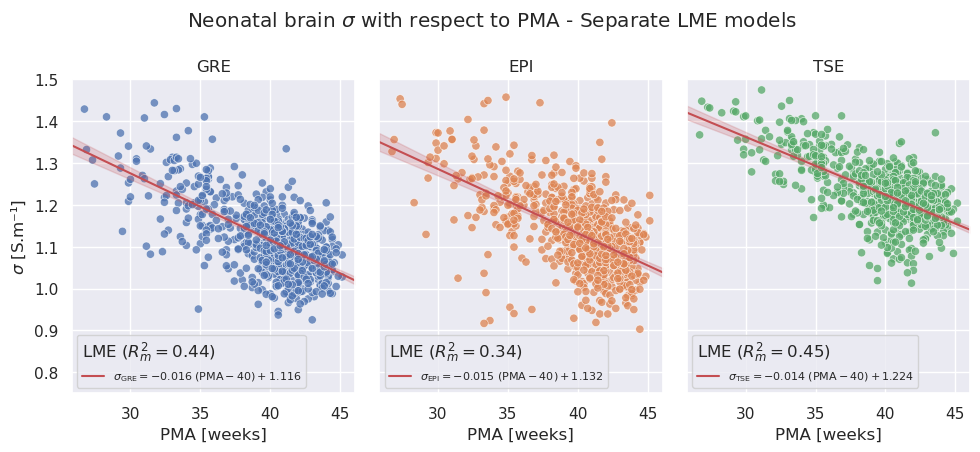

In [5]:
# Set file path
plot_path = os.path.join(plot_dir, "experiment2B.png")
summnary_dir = os.path.join(base_dir, "statsmodels")
summary_path = os.path.join(summnary_dir, "experiment2B.txt")

# Load dataframe
df = pd.read_csv(df_path)

# Data header
n = len(df.index)
x_col = "PMA"
y_col = "brain_SIG"
cohort_labels = ["GRE", "EPI", "TSE"]
groups_col = "subject_id"

# Axis limit with margin
xlim = calculate_plot_lim(df[x_col], coeff_margin=0.05)
ylim = [0.75, 1.5]

# Adjust PMA
x_display_offset = 40
df[x_col] -= x_display_offset
xlim_pred = [xlim[0] - x_display_offset, xlim[1] - x_display_offset]

# Initialize output directories
for path in [summary_path, plot_path]:
    output_dir = os.path.dirname(path)
    os.makedirs(output_dir, exist_ok=True)
    
# Initialize plot
fig, axes = plt.subplots(1, 3, figsize=(10,4.6), sharey=True, sharex=True)
fig.suptitle(r"Neonatal brain $\sigma$ with respect to PMA - Separate LME models")

# Iter over measurements
for i, cohort in enumerate(cohort_labels):

    # Fit mixed effects model
    formula = f"{cohort}_{y_col} ~ {x_col}"
    lme = smf.mixedlm(formula, df, groups=df[groups_col]).fit(reml=False)

    # Coefficients of determination
    marginal_r2, conditional_r2 = lme_coefficient_determination(lme, df)

    # Confidence interval
    pred_df = lme_confidence_interval(lme, df, x_col, xlim_pred)

    # Transform X for plotting
    df["x_disp"] = df[x_col] + x_display_offset
    pred_df["x_disp"] = pred_df[x_col] + x_display_offset

    # Plot data
    sns.scatterplot(data=df, x="x_disp", y=f"{cohort}_{y_col}", ax=axes[i], alpha=0.75, 
                    hue=n*[cohort], hue_order=cohort_labels, legend=None)

    # Label
    slope = lme.params[x_col]
    intercept = lme.params["Intercept"]
    slope_txt = f"{slope:.3f}"
    coeff_txt = rf"\; (\mathregular{{PMA}} - {x_display_offset})"
    intercept_txt = f"+ {intercept:.3f}" if intercept >= 0 else f"- {abs(intercept):.3f}"
    var_symbol = rf"\sigma_{{\mathregular{{{cohort}}}}}"
    label = f"${var_symbol} = {slope_txt}{coeff_txt} {intercept_txt}$"
    
    # Regression line and confidence interval
    axes[i].plot(pred_df["x_disp"], pred_df["Predicted"], color="r", label=label)
    axes[i].fill_between(pred_df["x_disp"], pred_df["CI_lower"], pred_df["CI_upper"], color="r", alpha=0.2)

    # Labels and limits
    axes[i].set_title(cohort)
    axes[i].set_xlabel("PMA [weeks]")
    axes[i].set_ylabel(r"$\sigma$ [S.m⁻¹]")
    axes[i].set_xlim(xlim)
    axes[i].set_ylim(ylim)

    # Legend
    leg = axes[i].legend(loc="lower left", title=f"LME ($R^2_m = {marginal_r2:.2f}$)", prop={'size': 8})
    leg._legend_box.align = "left"
    
    # Write summary
    write_mode = "a" if i else "w"
    with open(summary_path, write_mode) as fh:
        fh.write(lme.summary().as_text())
        fh.write(f"\nMarginal R² = {marginal_r2:.2f}, Conditional R² = {conditional_r2:.2f}\n\n")

# Save plot
fig.tight_layout()
plt.savefig(plot_path, bbox_inches='tight', dpi=300)

In [6]:
# Model summary
f = open(summary_path, 'r')
file_contents = f.read()
print(file_contents)
f.close()

           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: GRE_brain_SIG
No. Observations: 725     Method:             ML           
No. Groups:       650     Scale:              0.0035       
Min. group size:  1       Log-Likelihood:     982.5243     
Max. group size:  2       Converged:          Yes          
Mean group size:  1.1                                      
------------------------------------------------------------
            Coef.   Std.Err.     z     P>|z|  [0.025  0.975]
------------------------------------------------------------
Intercept    1.116     0.002  471.207  0.000   1.111   1.121
PMA         -0.016     0.001  -23.206  0.000  -0.017  -0.015
Group Var    0.000     0.006                                

Marginal R² = 0.44, Conditional R² = 0.49

           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: EPI_brain_SIG
No. Observations: 725     Method:             ML           
No. Groups: 

When plotted against PMA it is apparent that all three conductivity measurements obtained within the neonatal cohort have similar age dependence.

## 3.b. Joint LME model fitted to GRE, EPI and TSE $\sigma$ data with PMA as predictor variable
To assess the consistency of the decrease in brain conductivity across GRE, EPI and TSE measurements, we tested whether the respective slopes were parallel. We used LME models with subject-wise random effects to account for within-subject correlation between GRE, EPI and TSE measurements and neonatal subjects scanned during repeated sessions. We first fitted a full model with interactions between measurement type and conductivity-PMA slope (i.e. $\hat{\beta}_{\textrm{PMA}}^{\textrm{GRE}},\; \hat{\beta}_{\textrm{PMA}}^{\textrm{EPI}},\; \hat{\beta}_{\textrm{PMA}}^{\textrm{TSE}}$), and then fitted a restricted model without such interactions (i.e. including only intercept interactions $\hat{\beta}_{0}^{\textrm{GRE}},\; \hat{\beta}_{0}^{\textrm{EPI}},\; \hat{\beta}_{0}^{\textrm{TSE}}$). We computed a likelihood ratio test between the two models to assess whether interactions between measurement type and conductivity-PMA slope provided a better fit.

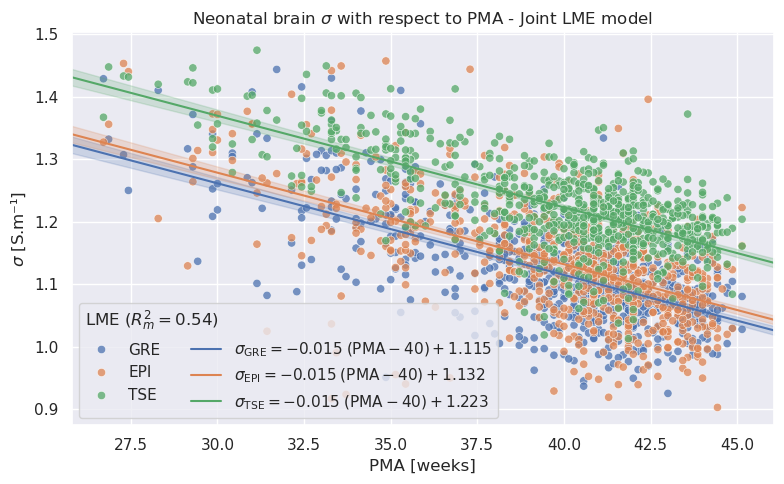

In [7]:
# File path
plot_path = os.path.join(plot_dir, "experiment2C.png")
summary_path = os.path.join(summnary_dir, "experiment2C.txt")

# Load dataframe
df = pd.read_csv(df_path)

# Data header
x_col = "PMA"
y_col = "brain_SIG"
cohort_col = "cohort"
cohort_labels = ["GRE", "EPI", "TSE"]
groups_col = "subject_id"

# Axis limit with margin
xlim = calculate_plot_lim(df[x_col], coeff_margin=0.05)

# Adjust PMA
x_display_offset = 40
df[x_col] -= x_display_offset
xlim_pred = [xlim[0] - x_display_offset, xlim[1] - x_display_offset]

# Build vertical dataframe
vert_df = []
for cohort in cohort_labels:
    vert_df.append(pd.DataFrame({
        x_col: df[x_col].values,
        y_col: df[f"{cohort}_{y_col}"].values,
        cohort_col: cohort,
        groups_col: df[groups_col].values,
    }))

# Concatenate
vert_df = pd.concat(vert_df, ignore_index=True)

# Initialize output directories
for path in [summary_path, plot_path]:
    output_dir = os.path.dirname(path)
    os.makedirs(output_dir, exist_ok=True)

# Initialize plot
fig, ax = plt.subplots(1, 1, figsize=(8,5))
ax.set_title(r"Neonatal brain $\sigma$ with respect to PMA - Joint LME model")
palette = sns.color_palette()

# Fit mixed effects model (only intercept interactions)
formula = f"{y_col} ~ {x_col} + C({cohort_col}) - 1"
lme = smf.mixedlm(formula, vert_df, groups=vert_df[groups_col]).fit(reml=False)

# Coefficient of determination
marginal_r2, conditional_r2 = lme_coefficient_determination(lme, vert_df)

# Transform X for plotting
vert_df["x_disp"] = vert_df[x_col] + x_display_offset

# Plot data
sns.scatterplot(ax=ax, data=vert_df, x="x_disp", y=y_col, hue=cohort_col, hue_order=cohort_labels, legend="brief", alpha=0.75)

# Iter over measurements
for i, cohort in enumerate(cohort_labels):

    # Intercept interaction
    intercept = f"C({cohort_col})[{cohort}]"
    
    # Confidence interval
    pred_df = lme_confidence_interval(lme, vert_df, x_col, xlim_pred, intercept=intercept)

    # Transform X for plotting
    pred_df["x_disp"] = pred_df[x_col] + x_display_offset

    # Label
    slope = lme.params[x_col]
    intercept = lme.params[intercept]
    slope_txt = f"{slope:.3f}"
    coeff_txt = rf"\; (\mathregular{{PMA}} - {x_display_offset})"
    intercept_txt = f"+ {intercept:.3f}" if intercept >= 0 else f"- {abs(intercept):.3f}"
    var_symbol = rf"\sigma_{{\mathregular{{{cohort}}}}}"
    label = f"${var_symbol} = {slope_txt}{coeff_txt} {intercept_txt}$"
    
    # Regression line and confidence interval
    ax.plot(pred_df["x_disp"], pred_df["Predicted"], label=label)
    ax.fill_between(pred_df["x_disp"], pred_df["CI_lower"], pred_df["CI_upper"], color=palette[i], alpha=0.2)

# Labels and limits
ax.set_xlabel("PMA [weeks]")
ax.set_ylabel(r"$\sigma$ [S.m⁻¹]")
ax.set_xlim(xlim)

# Legend
leg = ax.legend(loc="lower left", ncol=2, title=f"LME ($R^2_m = {marginal_r2:.2f}$)")
leg._legend_box.align = "left"

# Save plot
fig.tight_layout()
plt.savefig(plot_path, bbox_inches='tight', dpi=300)

# Fit mixed effects model with intercept and slope interaction
formula = f"{y_col} ~ {x_col} + C({cohort_col})*{x_col} - {x_col} + C({cohort_col}) - 1"
lme_full = smf.mixedlm(formula, vert_df, groups=vert_df[groups_col]).fit(reml=False)

# Coefficients of determination
marginal_r2_full, conditional_r2_full = lme_coefficient_determination(lme_full, vert_df)

# Likelihood ratio test
lrdf, lrstat, lr_pvalue  = likelihood_ratio(lme_full, lme)

# Write summary
with open(summary_path, "w") as fh:
    fh.write(lme.summary().as_text())
    fh.write(f"\nMarginal R² = {marginal_r2:.2f}, Conditional R² = {conditional_r2:.2f}\n\n")
    fh.write(lme_full.summary().as_text())
    fh.write(f"\nMarginal R² = {marginal_r2_full:.2f}, Conditional R² = {conditional_r2_full:.2f}\n\n")
    fh.write(f"\nLikelihood ratio test, Chi2({lrdf}) = {lrstat:.2f}, p-val = {lr_pvalue:.4f}\n\n")

In [8]:
# Model summary
f = open(summary_path, 'r')
file_contents = f.read()
print(file_contents)
f.close()

          Mixed Linear Model Regression Results
Model:             MixedLM  Dependent Variable:  brain_SIG
No. Observations:  2175     Method:              ML       
No. Groups:        650      Scale:               0.0031   
Min. group size:   3        Log-Likelihood:      2967.2926
Max. group size:   6        Converged:           Yes      
Mean group size:   3.3                                    
----------------------------------------------------------
               Coef.  Std.Err.    z    P>|z| [0.025 0.975]
----------------------------------------------------------
C(cohort)[EPI]  1.132    0.002 468.142 0.000  1.127  1.137
C(cohort)[GRE]  1.115    0.002 461.114 0.000  1.110  1.120
C(cohort)[TSE]  1.223    0.002 505.825 0.000  1.218  1.228
PMA            -0.015    0.000 -33.221 0.000 -0.016 -0.014
Group Var       0.001    0.002                            

Marginal R² = 0.54, Conditional R² = 0.65

            Mixed Linear Model Regression Results
Model:               MixedLM   D

The a likelihood ratio test showed that the interaction terms between measurement type and $\sigma$-PMA association are not significant at the $\alpha = 0.01$ significance level ($\chi^2(2) = 7.22$, $\textit{p} = 0.027$). While the interaction model reached statistical significance at the conventional $\alpha = 0.05$ level ($\textit{p} = 0.027$), we applied a more conservative significance threshold of $\alpha = 0.01$ to better control for Type I error, especially in light of the large sample size. In other words, regression lines for $\sigma_{\textrm{GRE}}$, $\sigma_{\textrm{EPI}}$ and $\sigma_{\textrm{TSE}}$ measures with respect to PMA were considered parallel, with a common slope of $\hat{\beta}_{\textrm{PMA}} = -0.015 \pm 0.001\, [\textrm{S.m}^{-1}\textrm{week}^{-1}]$ and minor biases between intercepts. Such systematic biases (as also revealed by Bland-Altman analysis) may be due to the differences in image acquisitions and EPT reconstruction pipelines. In particular, we observed that $\beta_0^{\textrm{TSE}} > \beta_0^{\textrm{EPI}} > \beta_0^{\textrm{GRE}}$, which can be partly explained by the fact that the POCR method tend to overestimates conductivity.

## 4. LME regression of weighted average brain $\sigma$ versus PMA
To facilitate further statistical analysis, GRE, EPI and TSE measurements were combined into a single brain $\sigma$ value, calculated as a weighted average using the inverse of the within-brain (voxel-wise) standard deviation for each measurement in each subject as weights. Gestational age (GA) at birth is indicated as colour hue.

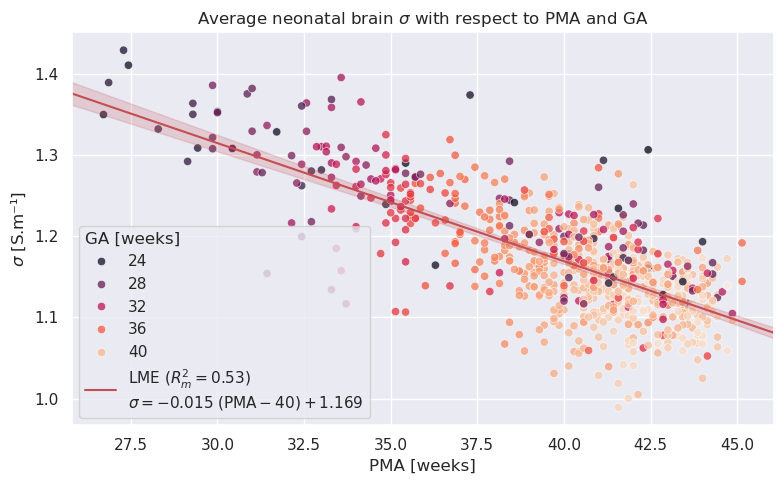

In [9]:
# Set fil path
plot_path = os.path.join(plot_dir, "experiment2D.png")
summary_path = os.path.join(summnary_dir, "experiment2D.txt")

# Load dataframe
df = pd.read_csv(df_path)

# Data header
x_col = "PMA"
y_col = "brain_SIG"
hue_col = "GA"
groups_col = "subject_id"

# Axis limit with margin
xlim = calculate_plot_lim(df[x_col], coeff_margin=0.05)

# Adjust PMA
x_display_offset = 40
df[x_col] -= x_display_offset
xlim_pred = [xlim[0] - x_display_offset, xlim[1] - x_display_offset]

# Get GA from PTB
df["GA"] = 37 - df["PTB"]

# Initialize output directories
for path in [summary_path, plot_path]:
    output_dir = os.path.dirname(path)
    os.makedirs(output_dir, exist_ok=True)

# Initialize plot
fig, ax = plt.subplots(1, 1, figsize=(8,5))
ax.set_title(r"Average neonatal brain $\sigma$ with respect to PMA and GA")

# Fit mixed effects model
formula = f"{y_col} ~ {x_col}"
lme = smf.mixedlm(formula, df, groups=df[groups_col]).fit(reml=False)

# Coefficients of determination
marginal_r2, conditional_r2 = lme_coefficient_determination(lme, df)

# Confidence interval
pred_df = lme_confidence_interval(lme, vert_df, x_col, xlim_pred)

# Transform X for plotting
df["x_disp"] = df[x_col] + x_display_offset
pred_df["x_disp"] = pred_df[x_col] + x_display_offset

# Plot data
sns.scatterplot(ax=ax, data=df, x="x_disp", y=y_col, hue=hue_col, legend="brief", alpha=0.75, palette="rocket")

# Label
slope = lme.params[x_col]
intercept = lme.params["Intercept"]
slope_txt = f"{slope:.3f}"
coeff_txt = rf"\; (\mathregular{{PMA}} - {x_display_offset})"
intercept_txt = f"+ {intercept:.3f}" if intercept >= 0 else f"- {abs(intercept):.3f}"
var_symbol = r"\sigma"
label = rf"LME ($R^2_m = {marginal_r2:.2f}$)"
label = f"{label}\n${var_symbol} = {slope_txt}{coeff_txt} {intercept_txt}$"

# Regression line and confidence interval
ax.plot(pred_df["x_disp"], pred_df["Predicted"], color="r", label=label)
ax.fill_between(pred_df["x_disp"], pred_df["CI_lower"], pred_df["CI_upper"], color="r", alpha=0.2)

# Axes labels and limits
ax.set_xlabel("PMA [weeks]")
ax.set_ylabel(r"$\sigma$ [S.m⁻¹]")
ax.set_xlim(xlim)

# Legend
leg = ax.legend(loc="lower left", title="GA [weeks]")
leg._legend_box.align = "left"

# Save plot
fig.tight_layout()
plt.savefig(plot_path, bbox_inches='tight', dpi=300)

# Write summary
with open(summary_path, "w") as fh:
    fh.write(lme.summary().as_text())
    fh.write(f"\nMarginal R² = {marginal_r2:.2f}, Conditional R² = {conditional_r2:.2f}\n\n")

In [10]:
# Model summary
f = open(summary_path, 'r')
file_contents = f.read()
print(file_contents)
f.close()

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: brain_SIG
No. Observations: 725     Method:             ML       
No. Groups:       650     Scale:              0.0012   
Min. group size:  1       Log-Likelihood:     1190.0423
Max. group size:  2       Converged:          Yes      
Mean group size:  1.1                                  
-------------------------------------------------------
            Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept    1.169    0.002 637.317 0.000  1.166  1.173
PMA         -0.015    0.000 -30.475 0.000 -0.015 -0.014
Group Var    0.001    0.010                            

Marginal R² = 0.53, Conditional R² = 0.75




The obtained slope is similar to previous results and the marginal coefficient of determination for this measurement was $0.53$, indicating that more than half of the variation in $\sigma$ is explained by PMA during the neonatal period. The $R^2_m$ coefficient is also higher than its counterparts obtained from individual models, indicating more robust average $\sigma$ measurements.